In [8]:
import numpy as np
import pandas as pd
import os
import glob
from scipy.spatial.distance import pdist, squareform
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Data Process

In [9]:
def load_raw(csv_file):
    df = pd.read_csv(csv_file, header=None)
    coords = df.apply(lambda row: np.array([[int(y) for y in x.strip('[]').split(', ')] for x in row[1:]]), axis=1)
    coords_list = coords.tolist()
    return coords_list

def calculate_jcd(coords):
    distances = squareform(pdist(coords, 'euclidean'))
    tril_indices = np.tril_indices_from(distances, k=-1)
    jcd_features = distances[tril_indices]
    return jcd_features

def raw_process(file_path):
    raw_data = []
    coords_list = load_raw(file_path)
    for coords in coords_list:
        jcd_features = calculate_jcd(np.array(coords))
        raw_data.append(jcd_features)    
    raw_data_array = np.array(raw_data)
    raw_data_df = pd.DataFrame(raw_data_array)
    return raw_data_df

def save_jcd(raw_data_df, csv_file, save_dir):
    base_name = os.path.basename(csv_file)
    save_name = base_name.replace('keypoint', 'jcd')
    save_path = os.path.join(save_dir, save_name)
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    raw_data_df.to_csv(save_path, index=False, header=False)
    print(f"JCD features saved to {save_path}")

def process_jcd_files(data_dir, save_dir):
    csv_files = glob.glob(os.path.join(data_dir, '*.csv'))
    for csv_file in csv_files:
        raw_data_df = raw_process(csv_file)
        save_jcd(raw_data_df, csv_file, save_dir)

raw_dir = '../data/raw'
jcd_dir = '../data/jcd'
process_jcd_files(raw_dir, jcd_dir)

JCD features saved to ../data/jcd/jcd_0.csv
JCD features saved to ../data/jcd/jcd_1.csv
JCD features saved to ../data/jcd/jcd_2.csv
JCD features saved to ../data/jcd/jcd_3.csv
JCD features saved to ../data/jcd/jcd_4.csv
JCD features saved to ../data/jcd/jcd_5.csv
JCD features saved to ../data/jcd/jcd_6.csv
JCD features saved to ../data/jcd/jcd_7.csv
JCD features saved to ../data/jcd/jcd_8.csv
JCD features saved to ../data/jcd/jcd_9.csv
JCD features saved to ../data/jcd/jcd_10.csv
JCD features saved to ../data/jcd/jcd_11.csv
JCD features saved to ../data/jcd/jcd_12.csv
JCD features saved to ../data/jcd/jcd_13.csv
JCD features saved to ../data/jcd/jcd_14.csv
JCD features saved to ../data/jcd/jcd_15.csv


In [10]:
def merge_label_jcd(jcd_dir, save_path):
    all_jcd_data = []
    for jcd_file in glob.glob(os.path.join(jcd_dir, 'jcd_*.csv')):
        label = int(os.path.basename(jcd_file).split('_')[1].split('.')[0])
        df = pd.read_csv(jcd_file, header=None)
        df['label'] = label
        all_jcd_data.append(df)

    merged_df = pd.concat(all_jcd_data, ignore_index=True)
    merged_df = merged_df.sample(frac=1).reset_index(drop=True)
    merged_df.to_csv(save_path, index=False, header=False)
    print(f"Merged JCD data with labels saved to: {save_path}")

jcd_dir = '../data/jcd'
merge_path = '../data/merge_jcd.csv'
merge_label_jcd(jcd_dir, merge_path)

Merged JCD data with labels saved to: ../data/merge_jcd.csv


# Train

In [12]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model


def build_dd_net(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Dense(256, use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    x = Dense(128, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    x = Dense(64, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    return model


# # Example usage:
# input_shape = (231,)  # for example, 231 JCD features
# num_classes = 5  # assuming 5 classes for classification
#
# model = build_simplified_dd_net(input_shape, num_classes)
# model.summary()

In [13]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def load_data(csv_file):
    df = pd.read_csv(csv_file, header=None)
    X = df.iloc[:, :-1].apply(pd.to_numeric).values
    y = df.iloc[:, -1].apply(pd.to_numeric).values
    return X, y

RANDOM_SEED = 42
dataset = '../data/merge_jcd.csv'
model_save_path = '../models/ddnet_model.h5'

X, y = load_data('../data/merge_jcd.csv')
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.75, random_state=RANDOM_SEED)

input_shape = X_train.shape[1:] # (210,)
num_classes = len(set(y_train)) # 5
cp_callback = ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
es_callback = EarlyStopping(patience=100, verbose=1)

model = build_dd_net(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, 
    y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=128,
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
1/1 [==============================] - ETA: 0s - loss: 3.1049 - accuracy: 0.1083
Epoch 1: saving model to ../models/ddnet_model.h5
1/1 [==============================] - 2s 2s/step - loss: 3.1049 - accuracy: 0.1083 - val_loss: 21.7769 - val_accuracy: 0.0750
Epoch 2/1000
1/1 [==============================] - ETA: 0s - loss: 3.3696 - accuracy: 0.0417
Epoch 2: saving model to ../models/ddnet_model.h5
1/1 [==============================] - 0s 59ms/step - loss: 3.3696 - accuracy: 0.0417 - val_loss: 16.6157 - val_accuracy: 0.0250
Epoch 3/1000
1/1 [==============================] - ETA: 0s - loss: 3.4529 - accuracy: 0.0500
Epoch 3: saving model to ../models/ddnet_model.h5
1/1 [==============================] - 0s 61ms/step - loss: 3.4529 - accuracy: 0.0500 - val_loss: 13.3916 - val_accuracy: 0.0500
Epoch 4/1000
1/1 [==============================] - ETA: 0s - loss: 2.9261 - accuracy: 0.1083
Epoch 4: saving model to ../models/ddnet_model.h5


/home/jonathan/PycharmProjects/DD-Net/venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 66ms/step - loss: 2.9261 - accuracy: 0.1083 - val_loss: 11.6811 - val_accuracy: 0.0750
Epoch 5/1000
1/1 [==============================] - ETA: 0s - loss: 3.0585 - accuracy: 0.1250
Epoch 5: saving model to ../models/ddnet_model.h5
1/1 [==============================] - 0s 75ms/step - loss: 3.0585 - accuracy: 0.1250 - val_loss: 9.9454 - val_accuracy: 0.1500
Epoch 6/1000
1/1 [==============================] - ETA: 0s - loss: 2.9140 - accuracy: 0.1083
Epoch 6: saving model to ../models/ddnet_model.h5
1/1 [==============================] - 0s 56ms/step - loss: 2.9140 - accuracy: 0.1083 - val_loss: 8.9279 - val_accuracy: 0.1500
Epoch 7/1000
1/1 [==============================] - ETA: 0s - loss: 2.9248 - accuracy: 0.0833
Epoch 7: saving model to ../models/ddnet_model.h5
1/1 [==============================] - 0s 55ms/step - loss: 2.9248 - accuracy: 0.0833 - val_loss: 8.0102 - val_accuracy: 0.1500
Epoch 8/1000
1/1 [==============================] - ETA

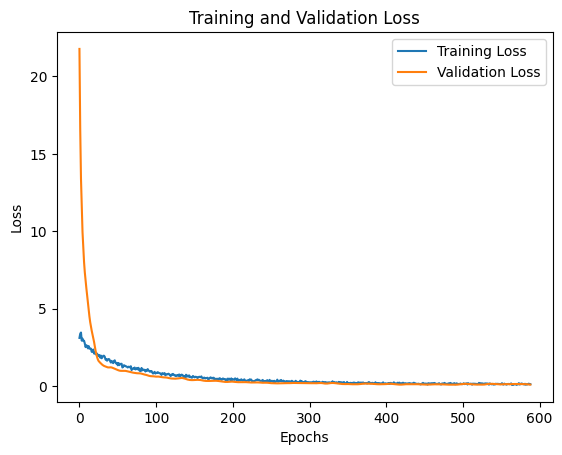

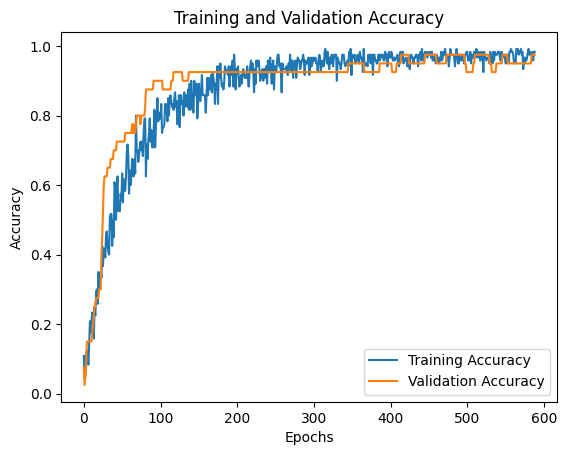

In [14]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()